In [2]:
import pandas as pd
import os.path
import numpy as np
import glob
from matplotlib import pyplot as plt
import seaborn as sns
import pingouin as pg
import openpyxl
import re
class StopCell(Exception): # a custom (mute) exception to exit cells programmatically ("raise StopCell")
    def _render_traceback_(self):
        pass

<mark> Dataframes :
- data_df : dataframe des behavioural data
- data_df_summary : dataframe des summary meca data
- filtered_df : summary meca data sans sujets practice
- filtered_df2 : summary meca data sans duplicates
- missing_df : dataframe des trials qui n'existent pas
- filtered_df2[mask] : dataframe sans valeurs outliers
- outlier_values : dataframe des essais avec au moins une valeur outlier
- df_result : behavioural data + summary meca data
- same_same_df : essais same-same

# Analysis Tactile Revcor
&copy; Céline Vanney, Etienne Louyot, JJ Aucouturier, PH Cornuault, Luc Carpentier


## Behavioural data

### Load Behavioural data

In [3]:
for file in glob.glob("./data/behaviour/*results*.csv"):
    print(file)

./data/behaviour\221110_08.22_results_subj6_soft.csv
./data/behaviour\221110_10.41_results_subj7_soft.csv
./data/behaviour\221110_14.16_results_subj8_soft.csv
./data/behaviour\221115_10.24_results_subj9_rug.csv
./data/behaviour\221116_15.47_results_subj10_rug.csv
./data/behaviour\221117_10.16_results_subj11_soft.csv
./data/behaviour\221117_15.45_results_subj12_rug.csv
./data/behaviour\221118_10.35_results_subj13_rug.csv
./data/behaviour\221121_08.55_results_subj14_soft.csv
./data/behaviour\221121_15.48_results_subj15_soft.csv
./data/behaviour\221122_08.42_results_subj16_soft.csv
./data/behaviour\221122_10.23_results_subj17_soft.csv
./data/behaviour\221122_14.05_results_subj18_soft.csv
./data/behaviour\221122_15.52_results_subj19_soft.csv
./data/behaviour\221123_10.28_results_subj20_soft.csv
./data/behaviour\221123_13.37_results_subj21_soft.csv
./data/behaviour\221124_13.36_results_subj22_soft.csv
./data/behaviour\221124_15.54_results_subj23_soft.csv
./data/behaviour\221125_09.06_result

#### Fix condition field & filename

Result files from participant 7 onwards include a `condition` field, and have their condition in the filename. Correct this for earlier participants. 

In [80]:
if True: raise StopCell

conditions = {'1':'rug', '2':'soft', '3':'soft',
             '4':'soft', '5':'soft','6':'soft'}

for participant in [6]: 
    
    # get participant file
    file = glob.glob("./data/behaviour/*results_subj%d*.csv"%participant)[0]
    
    # add condition in pandas
    condition = conditions[str(participant)]
    participant_data = pd.read_csv(file)
    participant_data['condition'] = condition
    
    # and save as new csv file with updated filename
    name, ext = os.path.splitext(os.path.basename(file))
    updated_filename = './data/behaviour/' + name + '_'+ condition + ext
    participant_data.to_csv(updated_filename,index=False)

#### Load all data

In [4]:
data_files = glob.glob("./data/behaviour/*_results_*.csv")
print("got %d behavioural files"%len(data_files))
data_df = pd.DataFrame()
for data_file in data_files:
    participant_data_df = pd.read_csv(data_file, sep = ',', decimal='.', header='infer')
    data_df = pd.concat([data_df, participant_data_df], ignore_index=True)
print('dataframe has %d subjects'%data_df.subj.nunique())

got 22 behavioural files
dataframe has 22 subjects


In [5]:
data_df

,subj,trial,block,practice,condition,sex,age,date,data_file,texture_id,stim_order,diameter,opening,spacing,response,rt
0,6,0,0,True,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block0_trial0_...,E019,0,440.0,140.0,580.0,True,19.445
1,6,0,0,True,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block0_trial0_...,E027,1,170.0,80.0,250.0,False,19.445
2,6,1,0,True,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block0_trial1_...,E068,0,20.0,80.0,100.0,True,12.811
3,6,1,0,True,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block0_trial1_...,E079(S41),1,50.0,110.0,160.0,False,12.811
4,6,2,0,True,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block0_trial2_...,E075(S42),0,20.0,20.0,40.0,True,13.262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,27,22,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E078(S45),1,80.0,110.0,190.0,False,8.466
4616,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E038,0,110.0,80.0,190.0,True,7.617
4617,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E076(S43),1,50.0,50.0,100.0,False,7.617
4618,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E044,0,170.0,140.0,310.0,True,7.534


<mark> Remove (Sxx) alternate codes for textures

In [6]:
data_df.texture_id = data_df.texture_id.apply(lambda a: a[0:4]) # keep first 4 characters

<mark : > Changer les textures pour same-same

In [7]:
same_same_df = pd.read_excel('./data/Textures_same-same.xlsx')

In [8]:
same_same_df.rename(columns={'subject': 'subj','texture 1': 'texture_id'},inplace=True)
same_same_df['texture_id'] = same_same_df['texture_id'].apply(lambda x: f"E0{x:02}")
same_same_df['texture 2'] = same_same_df['texture 2'].apply(lambda x: f"E0{x:02}")
same_same_df

,subj,block,trial,texture_id,texture 2
0,6,3,4,E036,E037
1,6,3,15,E010,E011
2,6,4,4,E036,E037
3,6,4,15,E010,E011
4,10,2,11,E019,E020
5,10,3,3,E046,E047
6,10,3,14,E013,E014
7,10,4,3,E046,E047
8,10,4,14,E013,E014
9,17,1,16,E002,E003


In [9]:
# Methode 1 :
for i in range(0,len(same_same_df)) :
    f = (data_df['subj'] == same_same_df.loc[i,'subj']) & (data_df['block'] == same_same_df.loc[i,'block']) & (data_df['trial'] == same_same_df.loc[i,'trial']) & (data_df['stim_order']==1)
    data_df.loc[f,'texture_id'] = same_same_df.loc[i,'texture 2']

In [10]:
data_df.texture_id.unique()

array(['E019', 'E027', 'E068', 'E079', 'E075', 'E009', 'E059', 'E018',
       'E016', 'E030', 'E064', 'E061', 'E006', 'E048', 'E038', 'E069',
       'E065', 'E028', 'E052', 'E017', 'E056', 'E034', 'E071', 'E072',
       'E076', 'E021', 'E074', 'E024', 'E001', 'E033', 'E083', 'E057',
       'E055', 'E023', 'E070', 'E025', 'E081', 'E002', 'E013', 'E032',
       'E015', 'E007', 'E010', 'E003', 'E022', 'E043', 'E078', 'E020',
       'E035', 'E077', 'E046', 'E073', 'E031', 'E051', 'E067', 'E036',
       'E005', 'E058', 'E039', 'E040', 'E054', 'E037', 'E080', 'E042',
       'E026', 'E062', 'E029', 'E011', 'E066', 'E063', 'E044', 'E045',
       'E047', 'E053', 'E041', 'E008', 'E060', 'E012', 'E049', 'E004',
       'E050', 'E082', 'E084', 'E014'], dtype=object)

In [10]:
#Methode 2 : 

# same_same_df['key'] = same_same_df['subj'].astype(str) + '_' + same_same_df['block'].astype(str) + '_' + same_same_df['trial'].astype(str)
# data_df['key'] = data_df['subj'].astype(str) + '_' + data_df['block'].astype(str) + '_' + data_df['trial'].astype(str)

# merged = data_df.merge(
#     same_same_df[['key', 'texture 2']],
#     on='key',
#     how='inner'
# )

# data_df.loc[data_df['stim_order'] == 1, 'texture_id'] = merged.loc[data_df['stim_order'] == 1, 'texture 2']

# data_df.drop(columns=['key'], inplace=True)



In [11]:
data_df.groupby(['condition','sex']).subj.unique()

condition  sex
rug        f                                      [9, 10, 12]
           m                                     [13, 26, 27]
soft       f      [6, 11, 14, 15, 16, 18, 21, 22, 23, 24, 25]
           m                               [7, 8, 17, 19, 20]
Name: subj, dtype: object

In [12]:
print("%d textures différentes utilisées"%data_df.texture_id.nunique())

84 textures différentes utilisées


##### Remove skipped blocks

<Axes: xlabel='subj', ylabel='trial'>

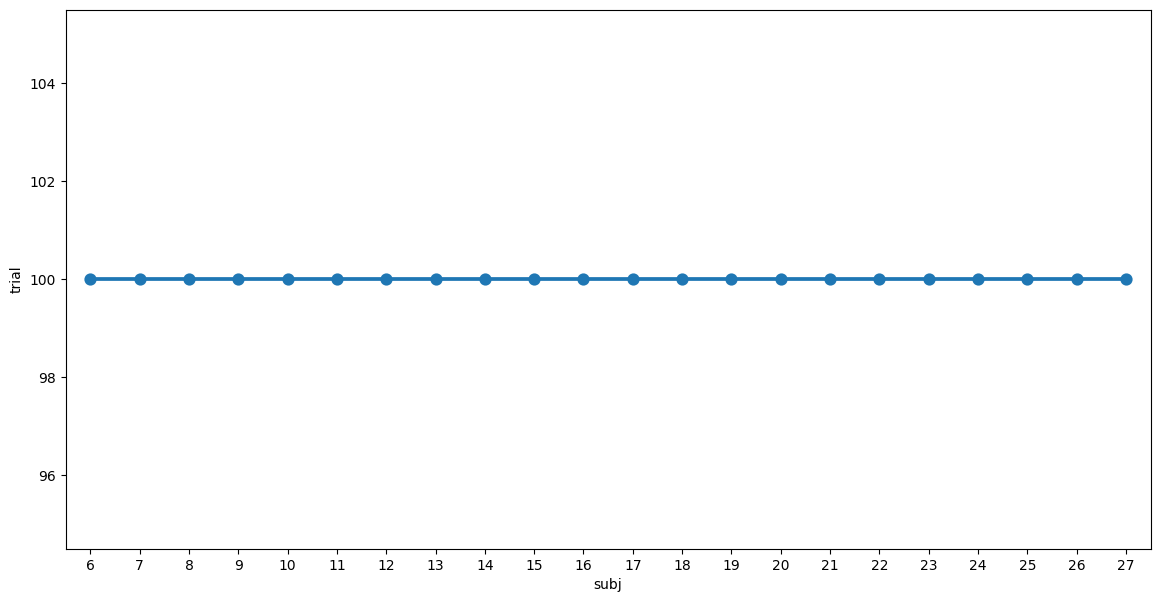

In [13]:
# all subjects have 100 trials
plt.figure(figsize=(14,7))
d=data_df[data_df.practice==False].groupby(['subj']).trial.count()/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

In [14]:
# remove practice block
data_df = data_df[data_df.block.isin([1,2,3,4])]
# data_df = data_df[data_df.practice==False]

In [16]:
data_df.reset_index(drop=True, inplace=True)
data_df

,subj,trial,block,practice,condition,sex,age,date,data_file,texture_id,stim_order,diameter,opening,spacing,response,rt
0,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,0,260.0,140.0,400.0,False,10.857
1,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E064,1,50.0,140.0,190.0,True,10.857
2,6,1,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial1.csv,E061,0,80.0,170.0,250.0,True,11.883
3,6,1,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial1.csv,E006,1,260.0,20.0,280.0,False,11.883
4,6,2,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial2.csv,E048,0,170.0,170.0,340.0,False,10.245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4395,27,22,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E078,1,80.0,110.0,190.0,False,8.466
4396,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E038,0,110.0,80.0,190.0,True,7.617
4397,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E076,1,50.0,50.0,100.0,False,7.617
4398,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E044,0,170.0,140.0,310.0,True,7.534


In [16]:
data_df.to_csv('data/behaviour/all_data.csv',index=False)

##### Number of different textures

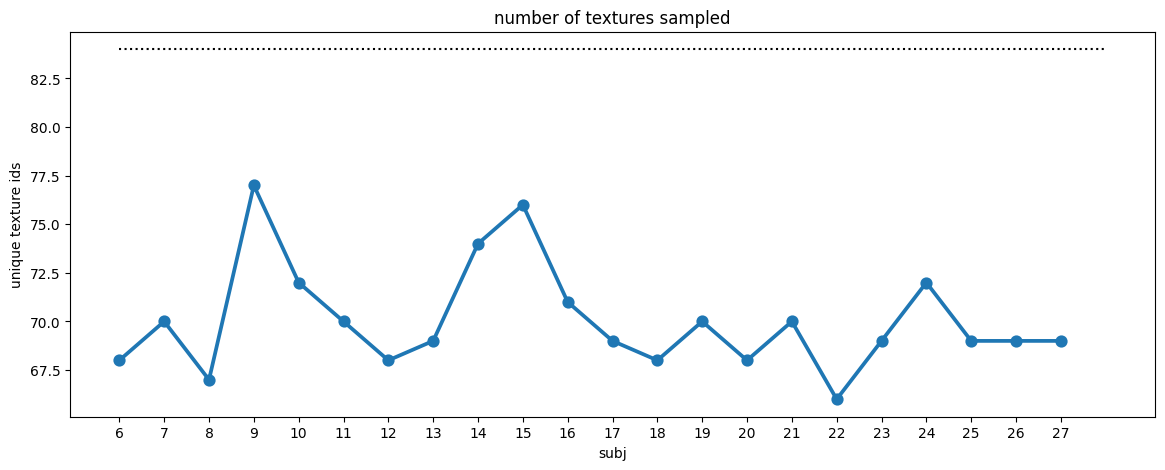

In [17]:
plt.figure(figsize=(14,5))
sns.pointplot(data=data_df.groupby('subj', as_index=False).texture_id.nunique(),
              x='subj',y='texture_id')

plt.title('number of textures sampled')
plt.ylabel('unique texture ids')

plt.plot([0,22],[data_df.texture_id.nunique(),data_df.texture_id.nunique()],'k:')


## Load summary meca data

### Load all data

In [18]:
data_summary = glob.glob("./data/meca/summary/*.xlsx")    
print("got %d summary files"%len(data_summary))
data_df_summary = pd.DataFrame()
for data_sum in data_summary:
    participant_data_summary = pd.read_excel(data_sum,engine="openpyxl")
    data_df_summary = pd.concat([data_df_summary, participant_data_summary], ignore_index=True)
print('dataframe has %d subjects'%data_df_summary.Subject.nunique())

got 9 summary files
dataframe has 23 subjects


In [19]:
data_df_summary


,Date (YYMMDD),Hour [h],Minute [min],Subject,Block,Trial,Texture,Start [s],End [s],Sliding distance [mm],V mean [mm/s],Fn mean [N],Fn std [N],Ft mean [N],Ft std [N],COF mean,COF std,RMS Accelero [m/s²]
0,221122,8,42,16,1,0,1,6.2692,6.8198,37.134524,67.936736,0.244839,0.081262,0.359014,0.075783,1.523927,0.218087,3.381203
1,221122,8,42,16,1,0,2,9.6768,10.3696,37.555220,53.228448,0.354724,0.038919,0.369661,0.026887,1.058695,0.168599,2.619718
2,221122,8,42,16,1,1,1,4.5892,5.2442,32.208557,48.929251,0.510734,0.031468,0.155038,0.012838,0.303306,0.011597,1.254451
3,221122,8,42,16,1,1,2,8.3478,9.2876,35.683789,38.321365,0.378196,0.023547,0.295779,0.043984,0.782811,0.112092,2.044252
4,221122,8,42,16,1,2,1,3.6212,4.4848,35.701824,41.388307,0.464945,0.025050,0.176368,0.016045,0.378981,0.022465,1.067344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,221125,17,18,27,4,22,2,4.7956,5.1706,35.853592,94.943428,1.574174,0.185896,0.564810,0.082925,0.357536,0.012494,6.140435
4197,221125,17,18,27,4,23,1,2.9734,3.5476,40.110299,73.018695,1.606961,0.068391,0.926973,0.076240,0.576235,0.029874,2.816130
4198,221125,17,18,27,4,23,2,5.0852,5.5312,35.825132,85.074553,1.676902,0.030933,0.750410,0.051388,0.447519,0.030270,1.416022
4199,221125,17,18,27,4,24,1,2.6174,3.2676,39.566893,60.739483,1.769655,0.085260,1.102541,0.186779,0.621689,0.096977,4.945476


### Convert columns names to snake_case

In [20]:
data_df_summary.rename(columns=lambda x: x[0].lower() + x.strip().lower().replace(' ', '_').title()[1:].lower(),inplace=True)  # snake_case
data_df_summary.rename(columns=lambda x: re.sub(r'[^a-z0-9_]', '', x.strip().lower().replace(' ', '_')), inplace=True)

In [21]:
data_df_summary.rename(columns={'subject': 'subj'},inplace=True)

### Sanity checks

<Axes: xlabel='subj', ylabel='trial'>

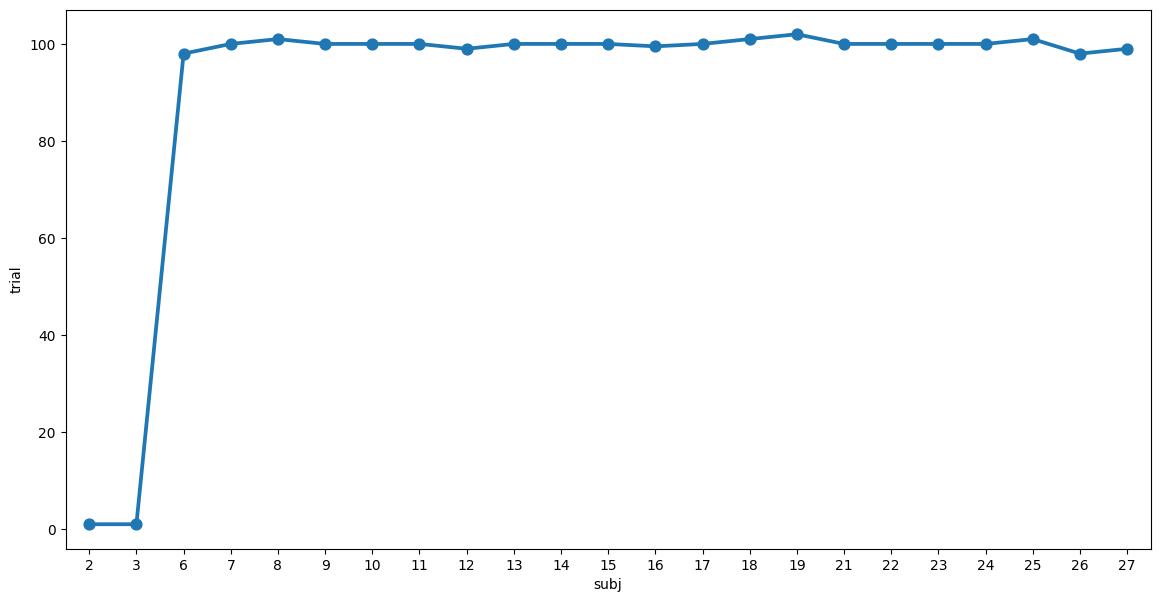

In [22]:
# Trials by subject
plt.figure(figsize=(14,7))
d=data_df_summary.groupby(['subj']).trial.count()/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

#### Remove subjects with not many trials

In [23]:
min_trials = 96  # choix arbitraire proche de 100 
filter = data_df_summary.groupby(['subj']).trial.count()/2 
reliable_subjects= filter[filter > min_trials].index   # get subjects who have more tha min_trials
filtered_df = data_df_summary[data_df_summary['subj'].isin(reliable_subjects)]   # another dataset with reliable_subjects only

In [24]:
filtered_df.groupby(['subj']).trial.count()/2

subj
6      98.0
7     100.0
8     101.0
9     100.0
10    100.0
11    100.0
12     99.0
13    100.0
14    100.0
15    100.0
16     99.5
17    100.0
18    101.0
19    102.0
21    100.0
22    100.0
23    100.0
24    100.0
25    101.0
26     98.0
27     99.0
Name: trial, dtype: float64

<Axes: xlabel='subj', ylabel='trial'>

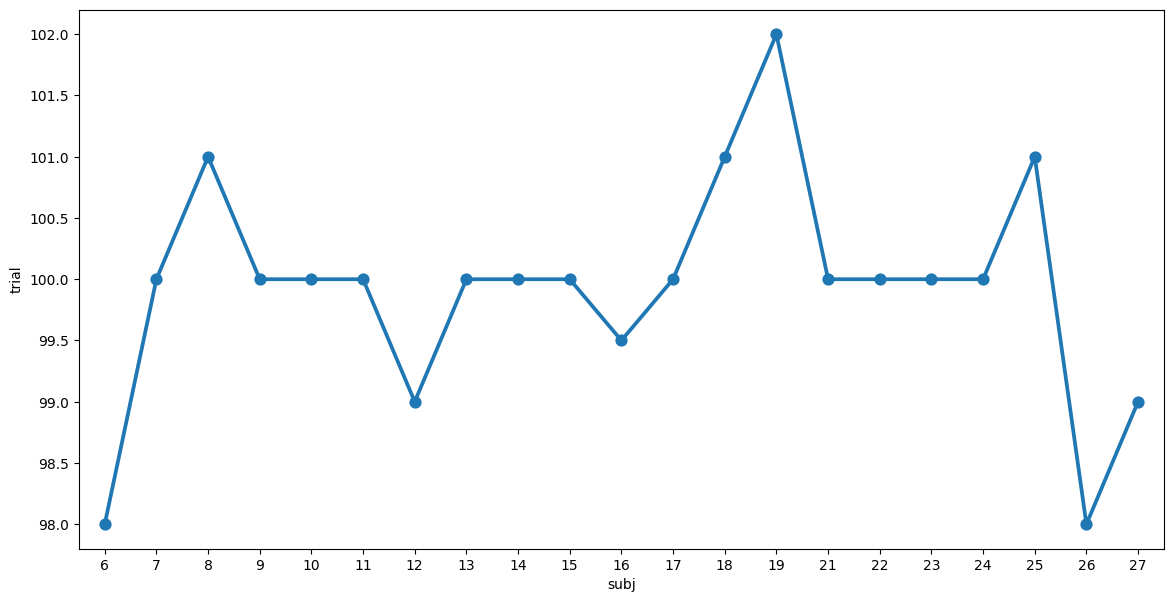

In [25]:
plt.figure(figsize=(14,7))
d=filtered_df.groupby(['subj']).trial.count()/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

### Find duplicates

In [26]:
a = filtered_df.groupby(['subj','block','trial','texture']).subj.count()
a[a>1]

subj  block  trial  texture
6     2      9      1          2
                    2          2
7     1      19     1          2
                    2          2
8     3      13     1          2
                    2          2
15    2      19     1          2
                    2          2
16    2      14     1          2
                    2          2
17    1      18     1          2
                    2          2
      4      3      1          2
                    2          2
18    4      12     1          2
                    2          2
19    2      11     1          2
                    2          2
             22     1          2
                    2          2
21    1      18     1          2
                    2          2
22    1      11     1          2
                    2          2
25    2      0      1          2
                    2          2
             7      1          2
                    2          2
27    1      4      1          3
               

In [27]:
list(filtered_df)

['date_yymmdd',
 'hour_h',
 'minute_min',
 'subj',
 'block',
 'trial',
 'texture',
 'start_s',
 'end_s',
 'sliding_distance_mm',
 'v_mean_mms',
 'fn_mean_n',
 'fn_std_n',
 'ft_mean_n',
 'ft_std_n',
 'cof_mean',
 'cof_std',
 'rms_accelero_ms']

In [28]:
filtered_df2 = filtered_df

filtered_df2 = filtered_df2.groupby(['date_yymmdd',
                       'hour_h',
                       'minute_min',
                       'subj',
                       'block',
                       'trial',
                       'texture'], as_index=False)[['start_s',
                                                    'end_s',
                                                    'sliding_distance_mm',
                                                    'v_mean_mms',
                                                    'fn_mean_n',
                                                    'fn_std_n',
                                                    'ft_mean_n',
                                                    'ft_std_n',
                                                    'cof_mean',
                                                    'cof_std',
                                                    'rms_accelero_ms']].mean().reset_index()



In [29]:
a = filtered_df2.groupby(['subj','block','trial','texture']).subj.count()
a[a>1]

Series([], Name: subj, dtype: int64)

### Find missing trials

In [30]:
missing = [] 
subjects = np.arange(6,28)
subjects = subjects[subjects != 20]
blocks = np.arange(1,5)
trials = np.arange(0,25)
textu = np.arange(1,3)
for i in subjects :
    for j in blocks :
        for n in trials :
            for m in textu :
                f = ( filtered_df['subj'] == i ) & (filtered_df['block'] == j ) & (filtered_df['trial'] == n) &  (filtered_df['texture'] == m)
                if filtered_df[f].empty :
                    missing.append([i,j,n,m])


missing_df = pd.DataFrame(missing, columns=["subj", "block", "trial", "texture"])


In [31]:
pd.set_option('display.max_rows',37)
missing_df

,subj,block,trial,texture
0,6,2,1,1
1,6,2,1,2
2,6,3,10,1
3,6,3,10,2
4,6,4,0,1
5,6,4,0,2
6,7,1,18,1
7,7,1,18,2
8,12,1,19,1
9,12,1,19,2


<Axes: xlabel='subj', ylabel='trial'>

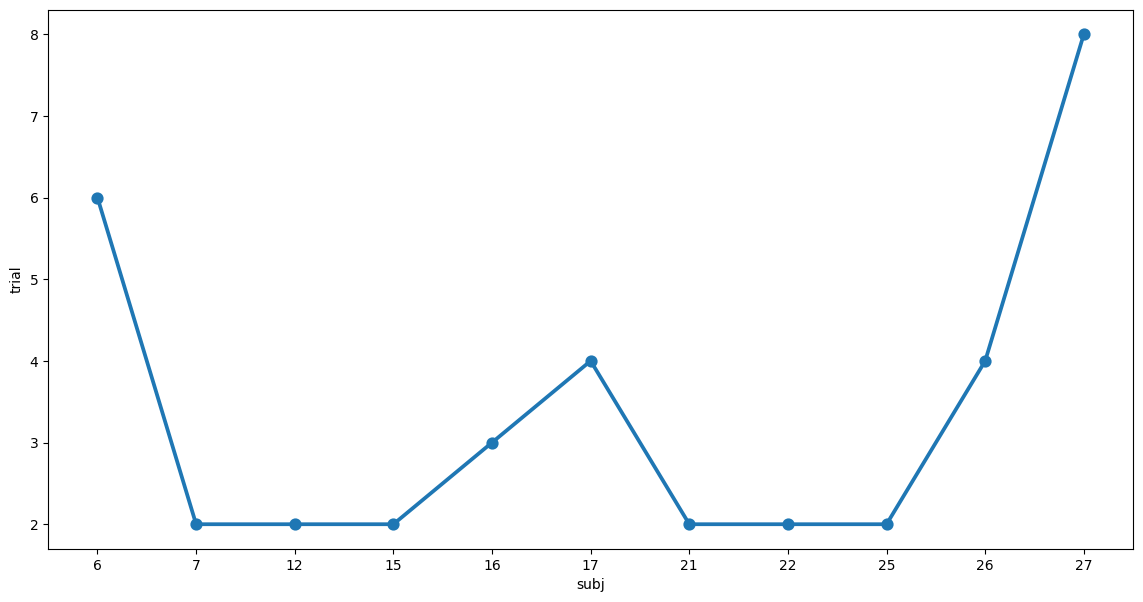

In [32]:
plt.figure(figsize=(14,7))
e=missing_df.groupby(['subj']).trial.count()
sns.pointplot(data=e.reset_index(), x='subj',y='trial')

In [33]:
# Trial qui a une seule texture :
b = missing_df.groupby(['subj','block','trial']).texture.count()
b[b % 2 !=0] 


subj  block  trial
16    2      13       1
Name: texture, dtype: int64

### Outlier values

In [34]:
filtered_df2.iloc[:, filtered_df2.columns.get_loc("sliding_distance_mm"):filtered_df2.columns.get_loc("rms_accelero_ms")].describe()

,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std
count,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000
mean,26.294998,42.057190,0.445305,0.037541,0.347640,0.036842,1.339869,12.054086
std,321.824258,1064.467510,0.463521,0.036763,0.284854,0.034650,5.247461,259.803593
min,-19560.044934,-65254.684509,-0.021901,0.005389,-0.069379,0.000223,-269.963031,0.000503
25%,28.166767,34.460162,0.177712,0.018695,0.160998,0.014207,0.451135,0.027654
50%,33.438019,45.902190,0.358293,0.027266,0.269053,0.026137,0.674465,0.060534
75%,38.600086,57.846558,0.533795,0.043392,0.428918,0.047160,1.235631,0.183048
max,1026.170755,13463.971511,4.890003,0.591267,2.159151,0.425295,93.620329,14313.955103


<Axes: xlabel='subj', ylabel='v_mean_mms'>

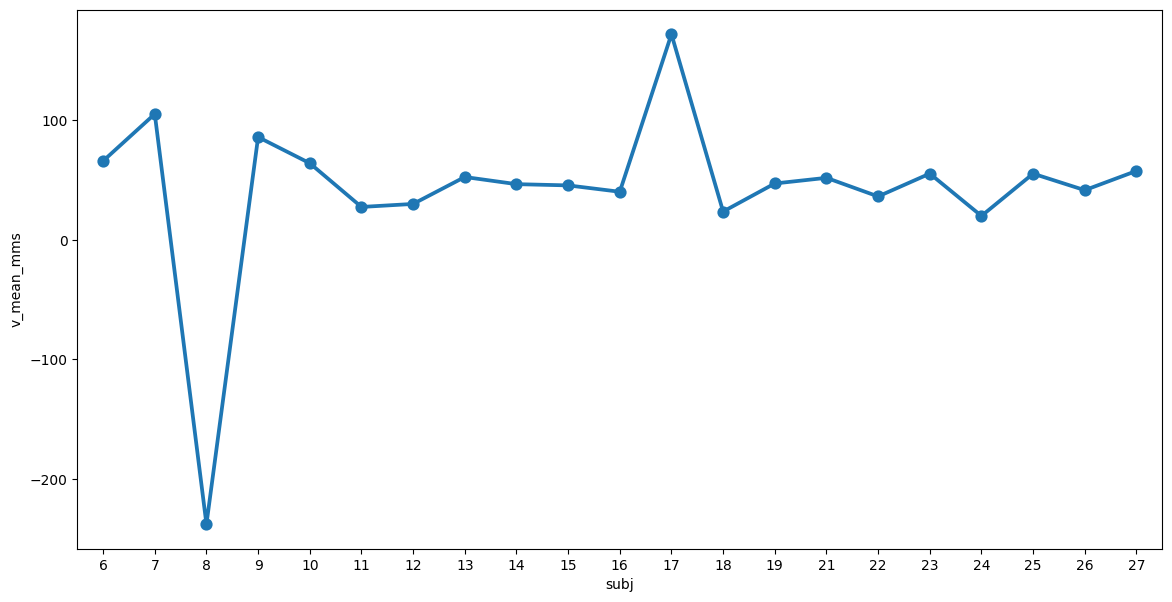

In [35]:
plt.figure(figsize=(14,7))
v_mean_by_subject = filtered_df2.groupby(['subj'])['v_mean_mms'].mean()   # v_mean() for each subject
sns.pointplot(data=v_mean_by_subject.reset_index(), x='subj',y='v_mean_mms')

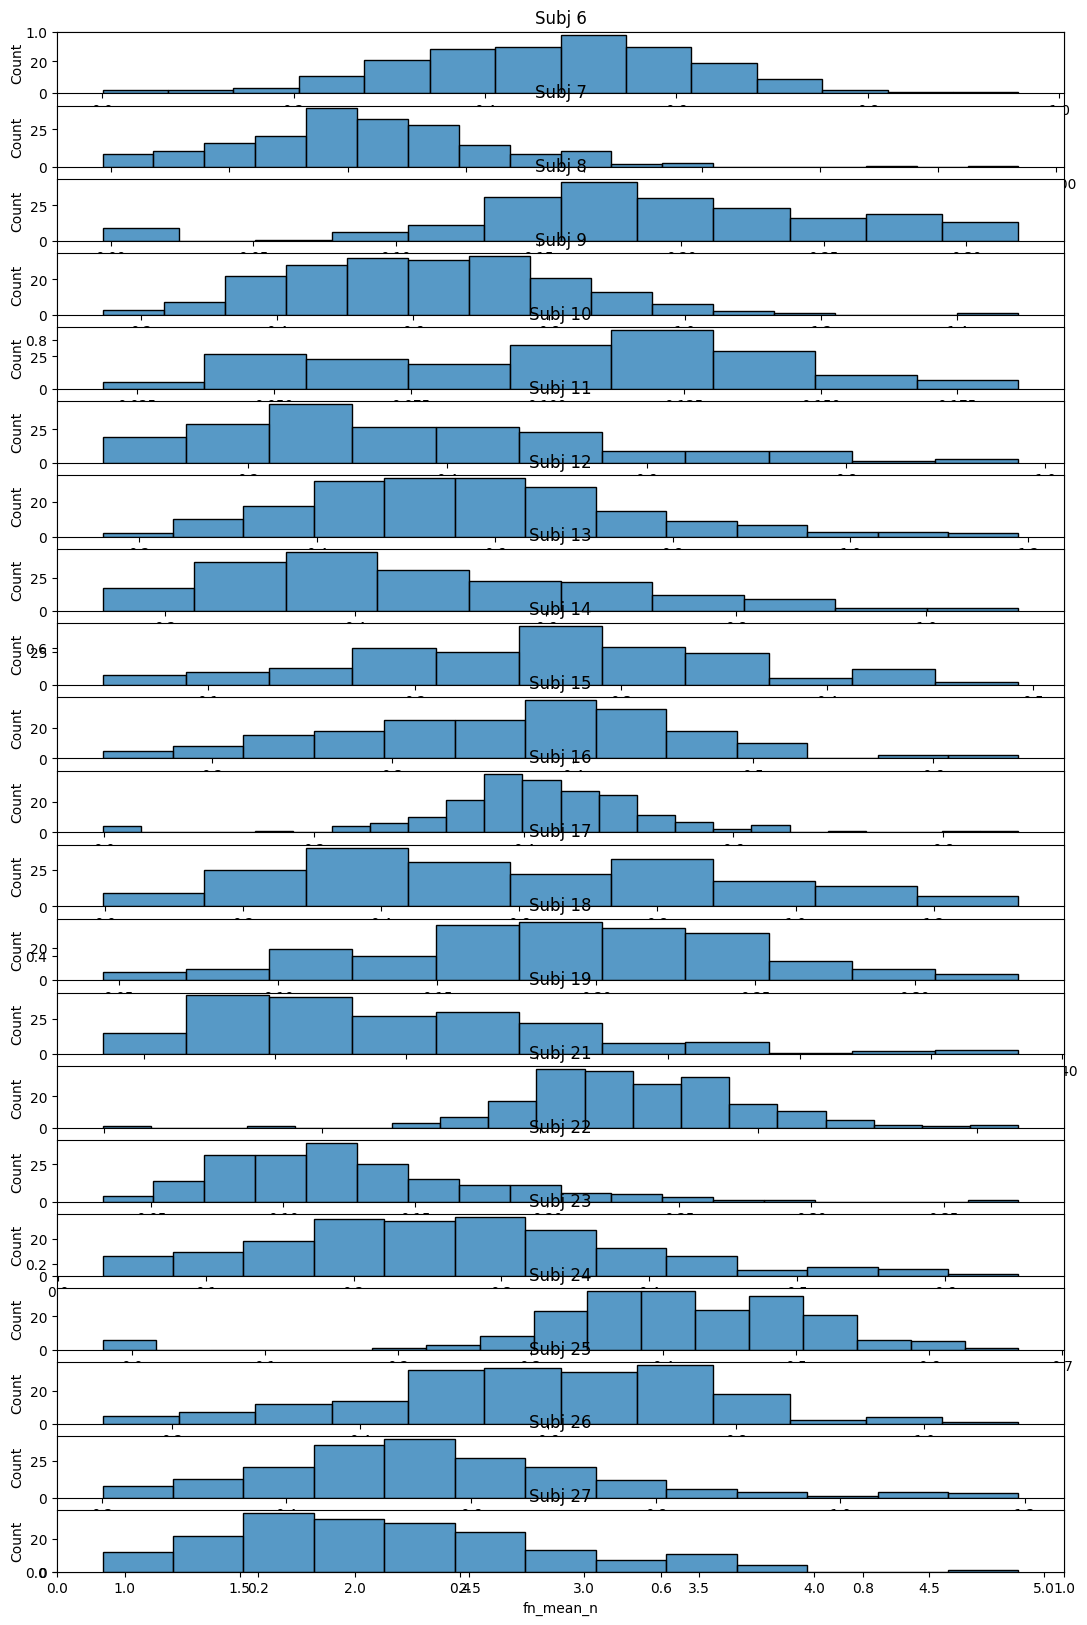

In [36]:
subjs = filtered_df2.subj.unique()  # from 6 to 27
plt.subplots(figsize=(13,20))
for ind, subj in enumerate(subjs): 
    plt.subplot(filtered_df2.subj.nunique(),1,ind+1)  # filtered_df2.subj.nunique() = 21 subplot , 
    sns.histplot(data=filtered_df2[filtered_df2.subj==subj],
                 x='fn_mean_n', label='%s'%subj)
    plt.title('Subj %s'%subj)
    


Text(0.5, 1.0, 'Distribution of sliding distance')

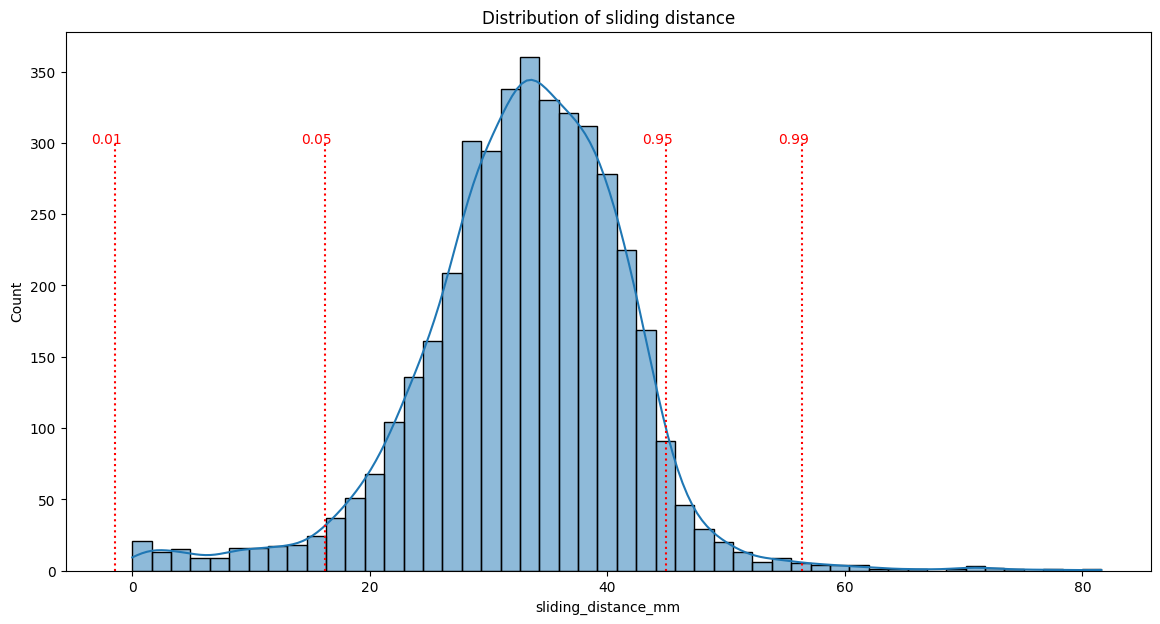

In [37]:
plt.figure(figsize=(14,7))
sns.histplot(data=filtered_df2[(filtered_df2.sliding_distance_mm>0)&
                      (filtered_df2.sliding_distance_mm<100)], x='sliding_distance_mm', bins=50, kde=True)

quantiles = [0.01, 0.05, 0.95, 0.99]
y_q = 300
for quantile in quantiles: 
    x_q = filtered_df2.sliding_distance_mm.quantile(quantile)
    plt.plot([x_q,x_q], [0,y_q],'r:')
    plt.text(x_q-2,y_q,'%.2f'%quantile, color='r')
plt.title('Distribution of sliding distance')


Text(0.5, 1.0, 'Distribution of V_mean')

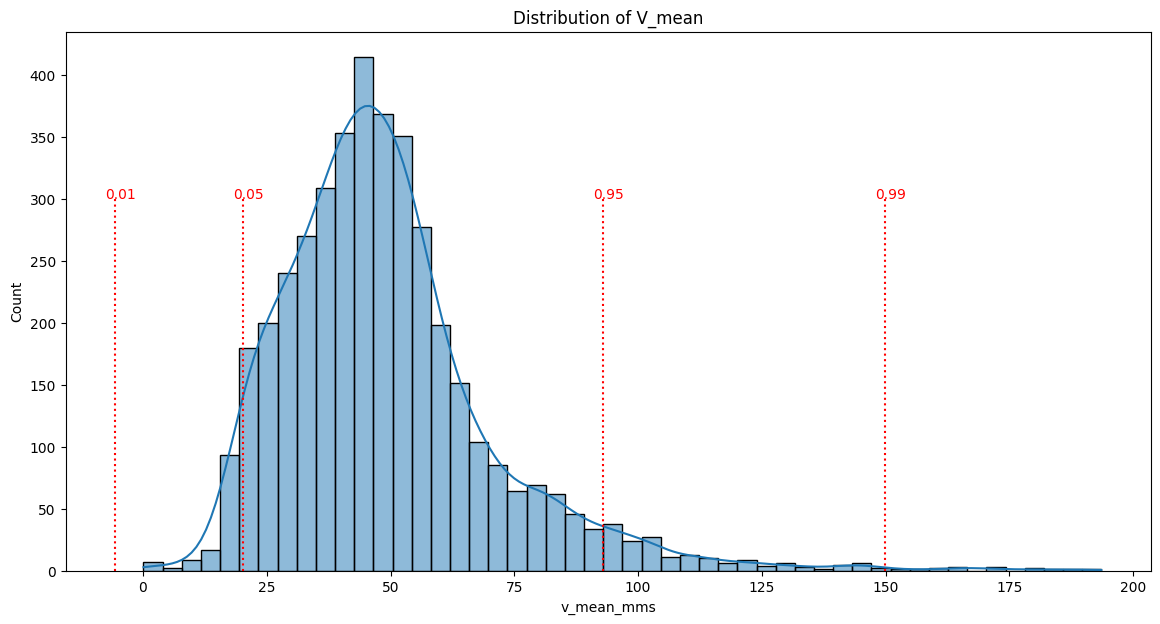

In [38]:
plt.figure(figsize=(14,7))
sns.histplot(data=filtered_df2[(filtered_df2.v_mean_mms>0)& (filtered_df2.v_mean_mms<200)], 
             x='v_mean_mms', bins=50,kde=True)

quantiles = [0.01, 0.05, 0.95, 0.99]
y_q = 300
for quantile in quantiles: 
    x_q = filtered_df2.v_mean_mms.quantile(quantile)
    plt.plot([x_q,x_q], [0,y_q],'r:')
    plt.text(x_q-2,y_q,'%.2f'%quantile, color='r')
plt.title('Distribution of V_mean')


Text(0.5, 1.0, 'Distribution of Fn_mean')

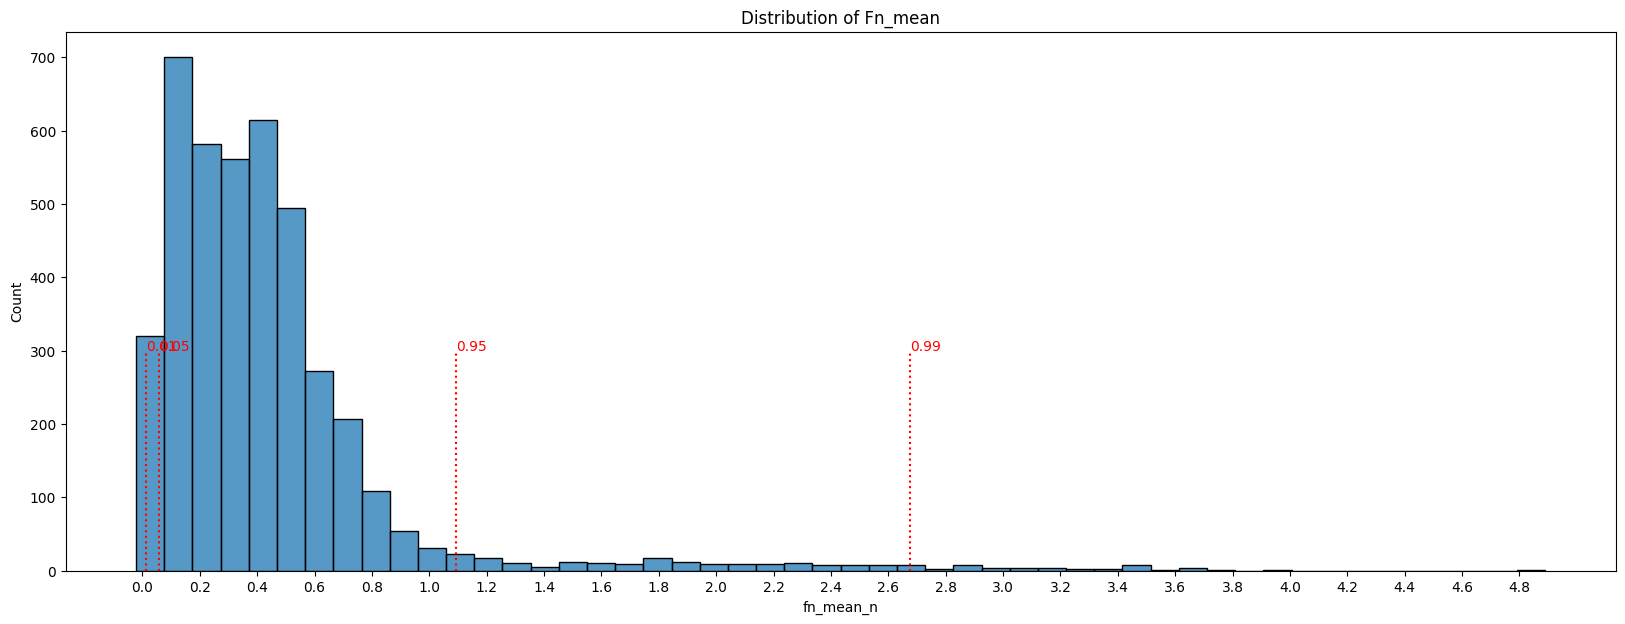

In [39]:
plt.figure(figsize=(20,7))
sns.histplot(data=filtered_df2,#[(df_2.fn_mean_n>0)& (df_2.fn_mean_n<200)], 
             x='fn_mean_n', bins=50)

quantiles = [0.01, 0.05, 0.95, 0.99]
y_q = 300
for quantile in quantiles: 
    x_q = filtered_df2.fn_mean_n.quantile(quantile)
    plt.plot([x_q,x_q], [0,y_q],'r:')
    plt.text(x_q,y_q,'%.2f'%quantile, color='r')
plt.xticks(np.arange(0,5,0.2))
plt.title("Distribution of Fn_mean")


Text(0.5, 1.0, 'Distribution of Fn_stf')

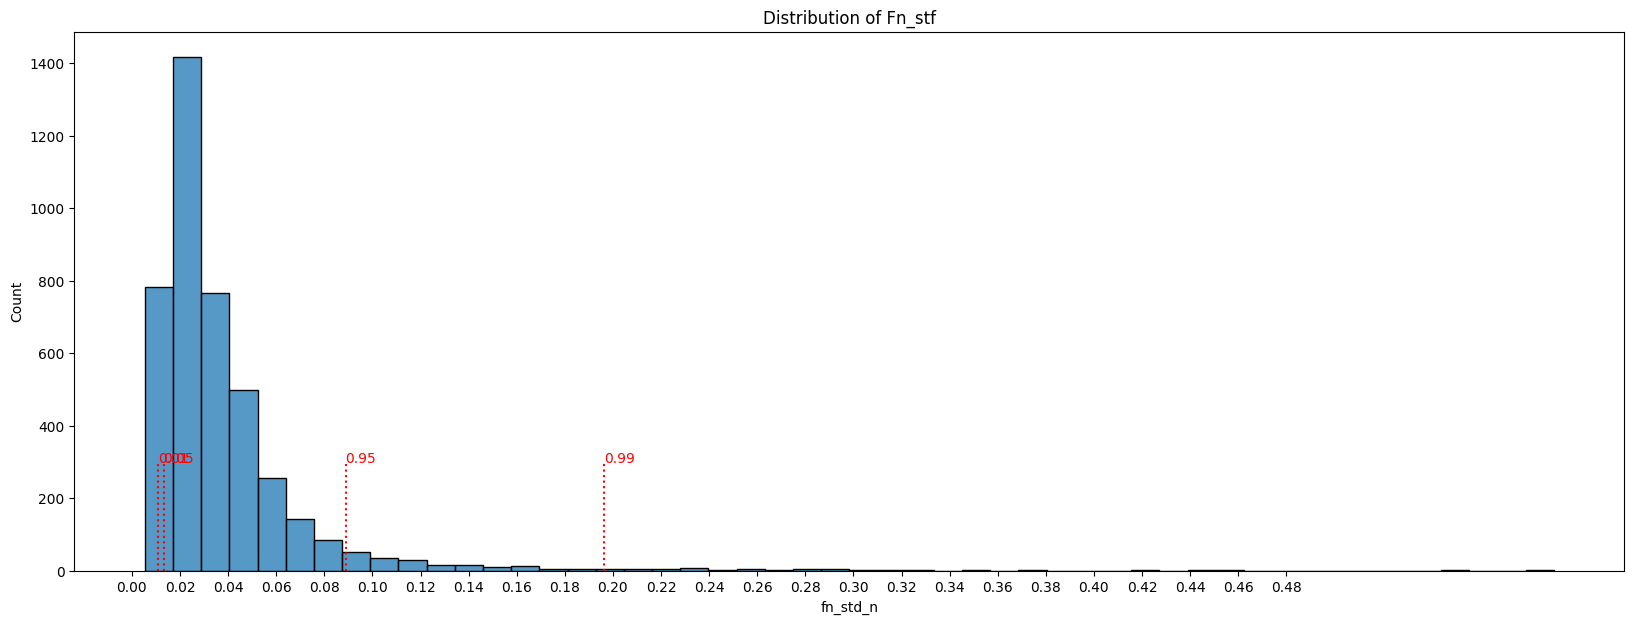

In [40]:
feature = 'fn_std_n'
plt.figure(figsize=(20,7))
sns.histplot(data=filtered_df2,#[(df_2[feature]>0)& (df_2[feature]<1)], 
             x=feature, bins=50)

quantiles = [0.01, 0.05, 0.95, 0.99]
y_q = 300
for quantile in quantiles: 
    x_q = filtered_df2[feature].quantile(quantile)
    plt.plot([x_q,x_q], [0,y_q],'r:')
    plt.text(x_q,y_q,'%.2f'%quantile, color='r')
plt.xticks(np.arange(0,0.5,0.02))
plt.title("Distribution of Fn_stf")

Text(0.5, 1.0, 'Distribution of Ft_mean')

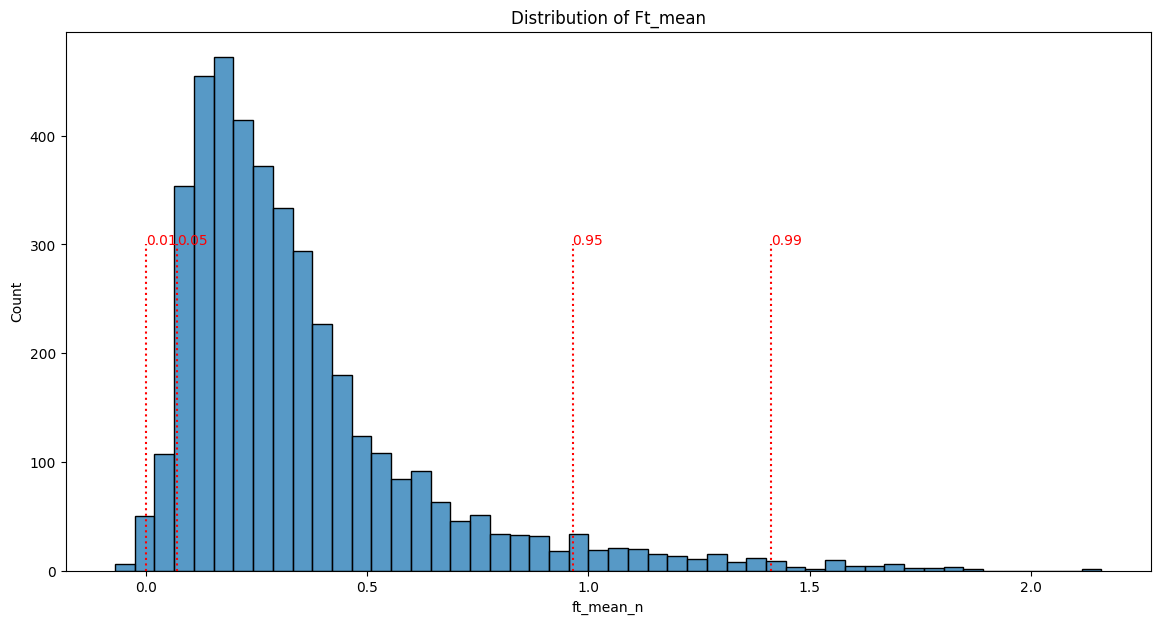

In [41]:
feature = 'ft_mean_n'
plt.figure(figsize=(14,7))
sns.histplot(data=filtered_df2,#[(df_2[feature]>0)& (df_2[feature]<1)], 
             x=feature, bins=50)

quantiles = [0.01, 0.05, 0.95, 0.99]
y_q = 300
for quantile in quantiles: 
    x_q = filtered_df2[feature].quantile(quantile)
    plt.plot([x_q,x_q], [0,y_q],'r:')
    plt.text(x_q,y_q,'%.2f'%quantile, color='r')
plt.title("Distribution of Ft_mean")


#### Filtrer les valeurs outliers

In [42]:
min_values ={'sliding_distance_mm':10,
             'v_mean_mms':0,
              'fn_mean_n':0.05,
             'fn_std_n':0,
             'ft_mean_n':0,
             'ft_std_n':0,
             'cof_mean':0,
             'cof_std':0,
              'rms_accelero_ms':0}   

max_values ={'sliding_distance_mm':70,
             'v_mean_mms':150, 
              'fn_mean_n':2.5,
             'fn_std_n':10,
             'ft_mean_n':2.5,
             'ft_std_n':10,
             'cof_mean':10,
             'cof_std':10,
              'rms_accelero_ms':50}   

mask = True
for column in min_values: 
    column_mask = filtered_df2[column].between(left=min_values[column],
                        right=max_values[column])
    print('Column %s: kept %d/%d (%.2f %%) '%(column.upper(),
                                               column_mask.sum(),
                                               len(column_mask),
                                               100*column_mask.sum()/len(column_mask)))
    mask *= column_mask
    print('\t cumulative: kept %d/%d (%.2f %%) '%(mask.sum(),
                                               len(filtered_df2),
                                               100*mask.sum()/len(filtered_df2)))
    
filtered_df2[mask]


Column SLIDING_DISTANCE_MM: kept 4000/4163 (96.08 %) 
	 cumulative: kept 4000/4163 (96.08 %) 
Column V_MEAN_MMS: kept 4068/4163 (97.72 %) 
	 cumulative: kept 3970/4163 (95.36 %) 
Column FN_MEAN_N: kept 3962/4163 (95.17 %) 
	 cumulative: kept 3837/4163 (92.17 %) 
Column FN_STD_N: kept 4163/4163 (100.00 %) 
	 cumulative: kept 3837/4163 (92.17 %) 
Column FT_MEAN_N: kept 4129/4163 (99.18 %) 
	 cumulative: kept 3834/4163 (92.10 %) 
Column FT_STD_N: kept 4163/4163 (100.00 %) 
	 cumulative: kept 3834/4163 (92.10 %) 
Column COF_MEAN: kept 4077/4163 (97.93 %) 
	 cumulative: kept 3817/4163 (91.69 %) 
Column COF_STD: kept 4091/4163 (98.27 %) 
	 cumulative: kept 3814/4163 (91.62 %) 
Column RMS_ACCELERO_MS: kept 4157/4163 (99.86 %) 
	 cumulative: kept 3808/4163 (91.47 %) 


,index,date_yymmdd,hour_h,minute_min,subj,block,trial,texture,start_s,end_s,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std,rms_accelero_ms
0,0,221110,8,22,6,1,0,1,2.4468,2.9188,27.336514,56.485055,0.101889,0.017506,0.411404,0.077333,4.112849,0.815765,4.338972
2,2,221110,8,22,6,1,1,1,3.2890,3.9926,32.968886,51.992636,0.232339,0.045522,0.284906,0.026106,1.257871,0.175839,2.376460
4,4,221110,8,22,6,1,2,1,2.7382,3.3636,48.907967,63.353527,0.124927,0.017377,0.408266,0.052771,3.309571,0.512267,2.498284
6,6,221110,8,22,6,1,3,1,2.9612,3.4458,35.732360,68.784172,0.295268,0.032018,0.177960,0.027178,0.600501,0.040334,1.157180
8,8,221110,8,22,6,1,4,1,2.4546,3.1166,28.167039,39.146747,0.257821,0.042836,0.367246,0.055283,1.430271,0.092177,1.715674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4158,4158,221125,17,18,27,4,22,2,4.7956,5.1706,35.853592,94.943428,1.574174,0.185896,0.564810,0.082925,0.357536,0.012494,6.140435
4159,4159,221125,17,18,27,4,23,1,2.9734,3.5476,40.110299,73.018695,1.606961,0.068391,0.926973,0.076240,0.576235,0.029874,2.816130
4160,4160,221125,17,18,27,4,23,2,5.0852,5.5312,35.825132,85.074553,1.676902,0.030933,0.750410,0.051388,0.447519,0.030270,1.416022
4161,4161,221125,17,18,27,4,24,1,2.6174,3.2676,39.566893,60.739483,1.769655,0.085260,1.102541,0.186779,0.621689,0.096977,4.945476


In [43]:
outlier_values = filtered_df2[~mask]
outlier_values

,index,date_yymmdd,hour_h,minute_min,subj,block,trial,texture,start_s,end_s,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std,rms_accelero_ms
1,1,221110,8,22,6,1,0,2,3.6468,4.1268,-1.195209,0.724558,0.374153,0.047508,0.378895,0.048208,1.031406,0.201548,0.349007
3,3,221110,8,22,6,1,1,2,5.2008,5.5466,70.677067,238.470067,0.014616,0.043763,0.023413,0.058613,0.494322,3.759739,0.899553
5,5,221110,8,22,6,1,2,2,3.7298,4.0166,-1.209241,-1.427792,0.528894,0.041373,0.492902,0.038785,0.941459,0.131747,0.270764
7,7,221110,8,22,6,1,3,2,4.0290,4.3712,-1.223049,-1.898012,0.687975,0.113679,0.073072,0.093514,0.084463,0.147489,0.036058
9,9,221110,8,22,6,1,4,2,3.7634,4.1966,-32.441522,11.586621,0.321707,0.230067,0.171209,0.124952,0.893950,11.793635,0.948186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4130,4130,221125,17,18,27,4,7,2,5.5252,6.1598,33.731069,56.872432,2.785975,0.069903,1.872526,0.052615,0.672394,0.020782,1.465334
4141,4141,221125,17,18,27,4,13,1,2.5178,3.3672,29.995917,36.425205,3.284163,0.591267,1.173982,0.283427,0.353522,0.024379,2.689930
4143,4143,221125,17,18,27,4,14,1,3.3276,4.1790,38.823252,45.952937,2.873847,0.131033,1.407756,0.122694,0.489034,0.025007,3.045192
4150,4150,221125,17,18,27,4,17,2,5.6646,6.6204,36.047577,39.548839,1.187908,0.070579,1.576069,0.294561,1.330550,0.259353,97.917783


In [44]:
outlier_values.to_excel('data/meca/out.xlsx')

In [45]:
filtered_df2[mask].to_csv('data/meca/meca.csv')

<mark> 8.5% des essais ont été supprimés

<Axes: xlabel='subj', ylabel='trial'>

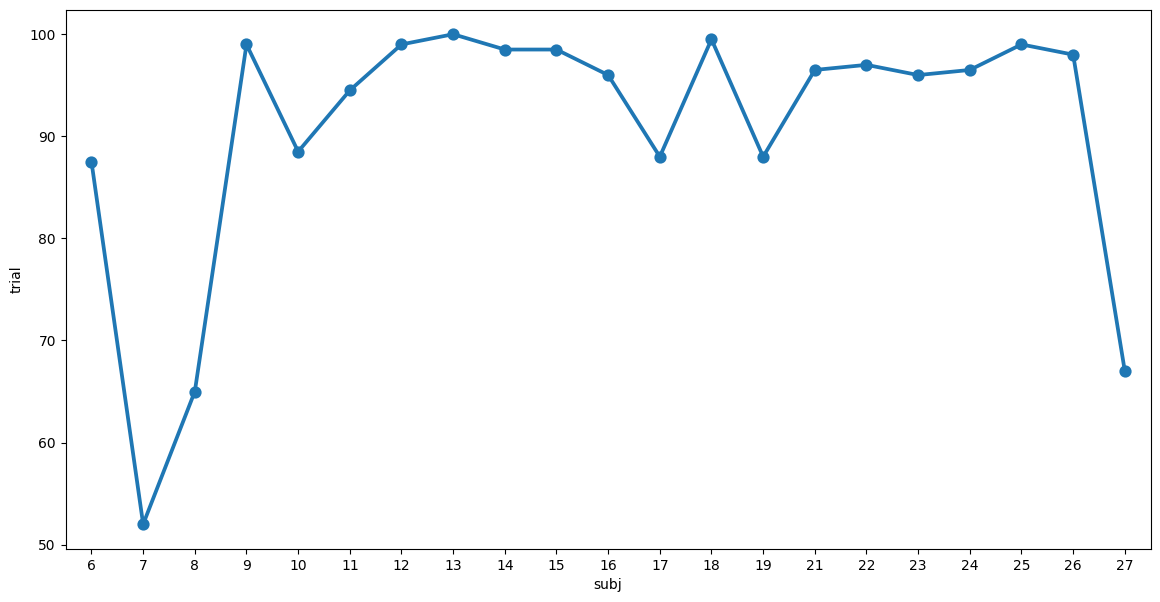

In [46]:
plt.figure(figsize=(14,7))
d=filtered_df2[mask].groupby(['subj']).trial.count()/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

(-1.0, 21.0)

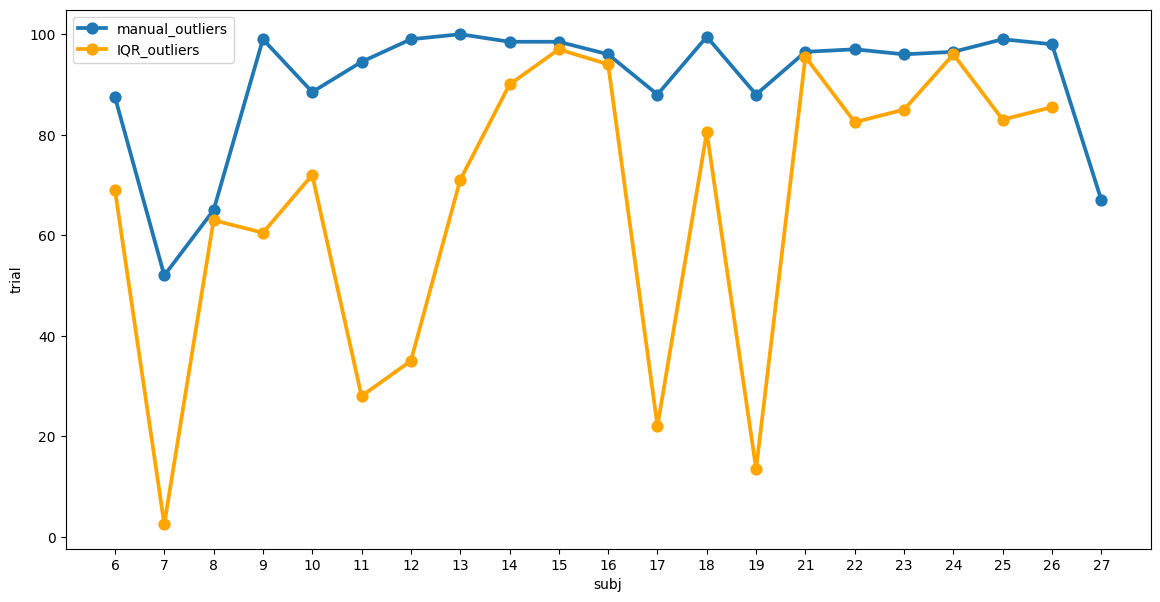

In [47]:
plt.figure(figsize=(14,7))
d=filtered_df2[mask].groupby(['subj']).trial.count()/2

sns.pointplot(data=d.reset_index(), x='subj',y='trial', label='manual_outliers')

# Methode des ecart interquartiles IQR :

Q1 = filtered_df2.quantile(0.25)
Q3 = filtered_df2.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#outliers = ((filtered_df2 < lower_bound) | (filtered_df2 > upper_bound)).sum()
filtered_df3 = filtered_df2[~((filtered_df2 < lower_bound) | (filtered_df2 > upper_bound)).any(axis=1)]

d2=filtered_df3.groupby(['subj']).trial.count()/2
sns.pointplot(data=d2.reset_index(), x='subj',y='trial', label='IQR_outliers', color='orange')
plt.legend()
plt.xlim([-1,21])

## Joindre behavioural data avec summary meca data

In [48]:
data_df.stim_order = data_df.stim_order +1 

g:\Utilisateurs\fouad.baamal\AppData\Local\Temp\ipykernel_2980\4052091906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.stim_order = data_df.stim_order +1


In [49]:
filtered_df2.rename(columns={'texture': 'stim_order'}, inplace=True)

In [50]:
df_result = pd.merge(data_df, filtered_df2[mask], on=['subj', 'trial','block','stim_order'], how='inner')

In [51]:
pd.set_option('display.max_columns',df_result.shape[1])
df_result

,subj,trial,block,practice,condition,sex,age,date,data_file,texture_id,stim_order,diameter,opening,spacing,response,rt,index,date_yymmdd,hour_h,minute_min,start_s,end_s,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std,rms_accelero_ms
0,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,0,221110,8,22,2.4468,2.9188,27.336514,56.485055,0.101889,0.017506,0.411404,0.077333,4.112849,0.815765,4.338972
1,6,1,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial1.csv,E061,1,80.0,170.0,250.0,True,11.883,2,221110,8,22,3.2890,3.9926,32.968886,51.992636,0.232339,0.045522,0.284906,0.026106,1.257871,0.175839,2.376460
2,6,2,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial2.csv,E048,1,170.0,170.0,340.0,False,10.245,4,221110,8,22,2.7382,3.3636,48.907967,63.353527,0.124927,0.017377,0.408266,0.052771,3.309571,0.512267,2.498284
3,6,3,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial3.csv,E069,1,20.0,140.0,160.0,True,9.698,6,221110,8,22,2.9612,3.4458,35.732360,68.784172,0.295268,0.032018,0.177960,0.027178,0.600501,0.040334,1.157180
4,6,4,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial4.csv,E028,1,500.0,260.0,760.0,True,9.379,8,221110,8,22,2.4546,3.1166,28.167039,39.146747,0.257821,0.042836,0.367246,0.055283,1.430271,0.092177,1.715674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3803,27,22,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E078,2,80.0,110.0,190.0,False,8.466,4158,221125,17,18,4.7956,5.1706,35.853592,94.943428,1.574174,0.185896,0.564810,0.082925,0.357536,0.012494,6.140435
3804,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E038,1,110.0,80.0,190.0,True,7.617,4159,221125,17,18,2.9734,3.5476,40.110299,73.018695,1.606961,0.068391,0.926973,0.076240,0.576235,0.029874,2.816130
3805,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E076,2,50.0,50.0,100.0,False,7.617,4160,221125,17,18,5.0852,5.5312,35.825132,85.074553,1.676902,0.030933,0.750410,0.051388,0.447519,0.030270,1.416022
3806,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E044,1,170.0,140.0,310.0,True,7.534,4161,221125,17,18,2.6174,3.2676,39.566893,60.739483,1.769655,0.085260,1.102541,0.186779,0.621689,0.096977,4.945476


In [52]:
df_result.to_csv('data/results.csv')

### Sanity check

In [53]:
results_df = pd.read_csv('data/results.csv', index_col=0)

In [54]:
# 210 trials ont 1 seule texture à signaux méca potables
a = df_result.groupby(['subj', 'block', 'trial'], as_index=False).stim_order.nunique()
pd.concat([a[a.stim_order==2].groupby('subj').trial.count(),
              a[a.stim_order==1].groupby('subj').trial.count()], axis=1).reset_index().set_index('subj')

,trial,trial
subj,,
6,78,19.0
7,35,34.0
8,34,62.0
9,98,2.0
10,78,21.0
11,89,11.0
12,99,NaN
13,100,NaN
14,98,1.0


Trois sujets ont beaucoup de trials manquants

In [55]:
df_result[df_result.subj.isin([7,8,27])].groupby('subj')[['age','sex','condition']].first()

,age,sex,condition
subj,,,
7,21,m,soft
8,21,m,soft
27,20,m,rug


In [56]:
df_result.groupby(['condition','sex']).subj.nunique()

condition  sex
rug        f       3
           m       3
soft       f      11
           m       4
Name: subj, dtype: int64

In [57]:
df_result

,subj,trial,block,practice,condition,sex,age,date,data_file,texture_id,stim_order,diameter,opening,spacing,response,rt,index,date_yymmdd,hour_h,minute_min,start_s,end_s,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std,rms_accelero_ms
0,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,0,221110,8,22,2.4468,2.9188,27.336514,56.485055,0.101889,0.017506,0.411404,0.077333,4.112849,0.815765,4.338972
1,6,1,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial1.csv,E061,1,80.0,170.0,250.0,True,11.883,2,221110,8,22,3.2890,3.9926,32.968886,51.992636,0.232339,0.045522,0.284906,0.026106,1.257871,0.175839,2.376460
2,6,2,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial2.csv,E048,1,170.0,170.0,340.0,False,10.245,4,221110,8,22,2.7382,3.3636,48.907967,63.353527,0.124927,0.017377,0.408266,0.052771,3.309571,0.512267,2.498284
3,6,3,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial3.csv,E069,1,20.0,140.0,160.0,True,9.698,6,221110,8,22,2.9612,3.4458,35.732360,68.784172,0.295268,0.032018,0.177960,0.027178,0.600501,0.040334,1.157180
4,6,4,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial4.csv,E028,1,500.0,260.0,760.0,True,9.379,8,221110,8,22,2.4546,3.1166,28.167039,39.146747,0.257821,0.042836,0.367246,0.055283,1.430271,0.092177,1.715674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3803,27,22,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E078,2,80.0,110.0,190.0,False,8.466,4158,221125,17,18,4.7956,5.1706,35.853592,94.943428,1.574174,0.185896,0.564810,0.082925,0.357536,0.012494,6.140435
3804,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E038,1,110.0,80.0,190.0,True,7.617,4159,221125,17,18,2.9734,3.5476,40.110299,73.018695,1.606961,0.068391,0.926973,0.076240,0.576235,0.029874,2.816130
3805,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E076,2,50.0,50.0,100.0,False,7.617,4160,221125,17,18,5.0852,5.5312,35.825132,85.074553,1.676902,0.030933,0.750410,0.051388,0.447519,0.030270,1.416022
3806,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E044,1,170.0,140.0,310.0,True,7.534,4161,221125,17,18,2.6174,3.2676,39.566893,60.739483,1.769655,0.085260,1.102541,0.186779,0.621689,0.096977,4.945476


## Kernel

### Kernel computation

In [58]:
results_df = pd.read_csv('data/results.csv', index_col=0)

In [59]:
data_melt = pd.melt(results_df,
        id_vars=['subj','trial','block','sex','age','condition','response', 'stim_order', 'texture_id'],
        value_vars=['sliding_distance_mm','v_mean_mms','fn_mean_n',
                    'fn_std_n','ft_mean_n','ft_std_n','cof_mean','cof_std','rms_accelero_ms', 'diameter','opening','spacing'],
        var_name='feature')

In [60]:
data_melt.sort_values(by=['subj','block','trial'])
data_melt

,subj,trial,block,sex,age,condition,response,stim_order,texture_id,feature,value
0,6,0,1,f,23,soft,False,1,E030,sliding_distance_mm,27.336514
1,6,1,1,f,23,soft,True,1,E061,sliding_distance_mm,32.968886
2,6,2,1,f,23,soft,False,1,E048,sliding_distance_mm,48.907967
3,6,3,1,f,23,soft,True,1,E069,sliding_distance_mm,35.732360
4,6,4,1,f,23,soft,True,1,E028,sliding_distance_mm,28.167039
...,...,...,...,...,...,...,...,...,...,...,...
45691,27,22,4,m,20,rug,False,2,E078,spacing,190.000000
45692,27,23,4,m,20,rug,True,1,E038,spacing,190.000000
45693,27,23,4,m,20,rug,False,2,E076,spacing,100.000000
45694,27,24,4,m,20,rug,True,1,E044,spacing,310.000000


In [61]:
# z-score feature values
zscore = lambda x: (x-np.nanmean(x))/np.nanstd(x)
# zscore TAS and weights
data_melt['value'] = data_melt.groupby(['subj','feature'])['value'].transform(zscore) 

# compute difference between positives and negatives in each trial
positives = data_melt.loc[data_melt.response == True].reset_index()
negatives = data_melt.loc[data_melt.response == False].reset_index()
kernels = pd.merge(positives, negatives, on=['subj','block','trial','feature'],suffixes=['+','-'])
kernels['delta_value']=kernels['value+']-kernels['value-']  
kernels.drop(['index+','response+', 'value+', 
               'index-', 'sex-', 'age-', 'condition-', 'response-', 'value-'], axis=1, inplace=True)
kernels = kernels.rename(columns={'sex+':'sex','age+':'age', 'condition+':'condition'}) 
kernels['square_delta_value'] = kernels['delta_value']**2

for_norm = kernels.groupby(['subj','condition','feature']).agg({'square_delta_value':'mean'}).reset_index()
kernels = pd.merge(kernels, for_norm, on=['subj','condition','feature'], suffixes=['','_mean'])
kernels['norm_delta_value'] = kernels['delta_value']/np.sqrt(kernels['square_delta_value_mean'])
kernels.drop(['delta_value','square_delta_value', 'square_delta_value_mean',], axis=1, inplace=True)
kernels



,subj,trial,block,sex,age,condition,stim_order+,texture_id+,feature,stim_order-,texture_id-,norm_delta_value
0,6,6,1,f,23,soft,2,E079,sliding_distance_mm,1,E034,-0.131869
1,6,7,1,f,23,soft,1,E034,sliding_distance_mm,2,E071,0.178866
2,6,10,1,f,23,soft,1,E048,sliding_distance_mm,2,E024,0.970793
3,6,12,1,f,23,soft,1,E017,sliding_distance_mm,2,E009,0.984866
4,6,13,1,f,23,soft,1,E083,sliding_distance_mm,2,E016,-0.496548
...,...,...,...,...,...,...,...,...,...,...,...,...
21583,27,18,4,m,20,rug,1,E059,spacing,2,E014,-0.628598
21584,27,19,4,m,20,rug,2,E050,spacing,1,E071,1.257195
21585,27,22,4,m,20,rug,1,E005,spacing,2,E078,0.733364
21586,27,23,4,m,20,rug,1,E038,spacing,2,E076,0.314299


In [62]:
kernels.sort_values(by=['subj','block','trial'])

,subj,trial,block,sex,age,condition,stim_order+,texture_id+,feature,stim_order-,texture_id-,norm_delta_value
0,6,6,1,f,23,soft,2,E079,sliding_distance_mm,1,E034,-0.131869
1799,6,6,1,f,23,soft,2,E079,v_mean_mms,1,E034,0.117833
3598,6,6,1,f,23,soft,2,E079,fn_mean_n,1,E034,-0.553907
5397,6,6,1,f,23,soft,2,E079,fn_std_n,1,E034,-1.663798
7196,6,6,1,f,23,soft,2,E079,ft_mean_n,1,E034,0.270430
...,...,...,...,...,...,...,...,...,...,...,...,...
14391,27,24,4,m,20,rug,1,E044,cof_std,2,E075,2.604110
16190,27,24,4,m,20,rug,1,E044,rms_accelero_ms,2,E075,0.965555
17989,27,24,4,m,20,rug,1,E044,diameter,2,E075,0.715337
19788,27,24,4,m,20,rug,1,E044,opening,2,E075,0.701838


### Different kernels per condition

In [63]:
kernels.groupby(['condition','feature']).norm_delta_value.mean()

condition  feature            
rug        cof_mean              -0.175100
           cof_std               -0.096255
           diameter              -0.101230
           fn_mean_n              0.262407
           fn_std_n               0.049806
           ft_mean_n             -0.127136
           ft_std_n              -0.138170
           opening                0.584957
           rms_accelero_ms        0.036898
           sliding_distance_mm    0.018419
           spacing                0.208000
           v_mean_mms            -0.162959
soft       cof_mean              -0.036983
           cof_std               -0.049842
           diameter              -0.013911
           fn_mean_n             -0.010812
           fn_std_n              -0.070713
           ft_mean_n             -0.079317
           ft_std_n              -0.036779
           opening               -0.498181
           rms_accelero_ms       -0.188881
           sliding_distance_mm   -0.007879
           spacing     

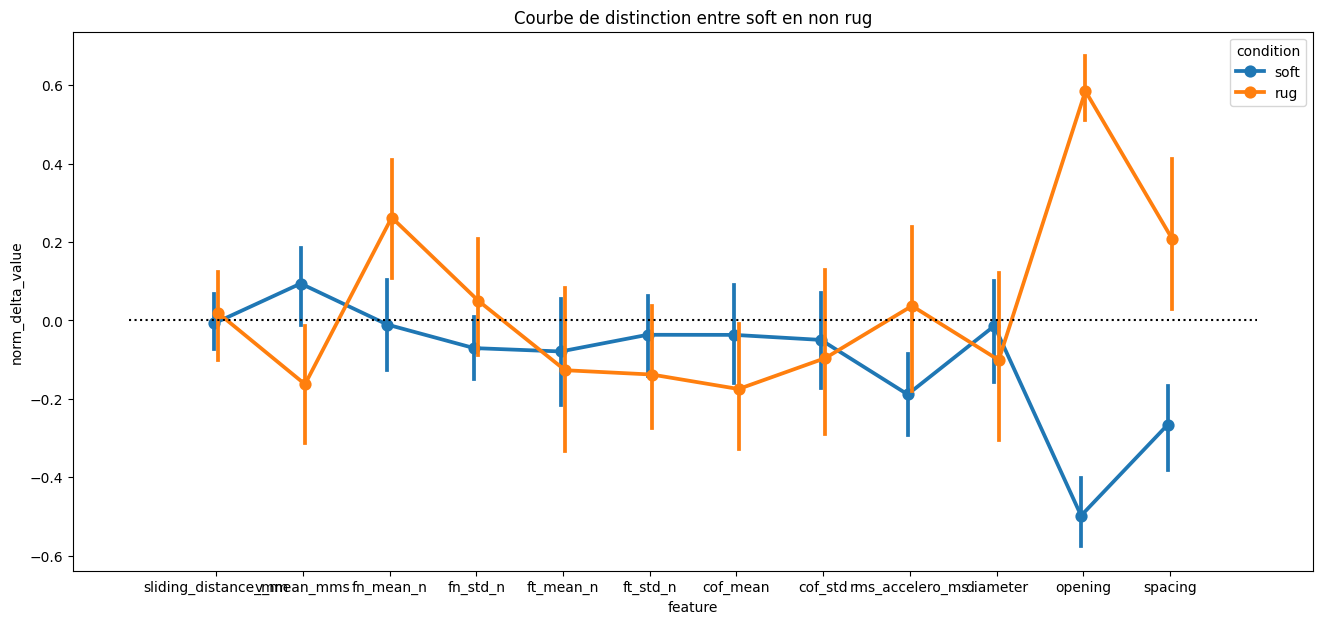

In [64]:
plt.figure(figsize=(16,7))
sns.pointplot(data=kernels,
              hue="condition",
             x="feature",
              units='subj',
             y="norm_delta_value", dodge=True)
plt.title("Courbe de distinction entre soft en non rug")
plt.plot([-1,12],[0,0],'k:')

# plot inverse rough kernel for comparison
#kernels['opposite_norm_delta_value'] = - kernels.norm_delta_value
#sns.pointplot(data=kernels[kernels.condition=='rug'],
#              hue="condition",
#             x="feature",
#              units='subj',
#             y="opposite_norm_delta_value", 
#              linestyles=[':'])

#plt.plot([0,2],[0,0],'k:')
#plt.legend(loc=2)

One-sample difference of kernel weights to zero

In [65]:
sample = kernels[(kernels.condition=="soft")&
                          (kernels.feature=='diameter')].groupby(['subj'], as_index=False).norm_delta_value.mean()
sample

,subj,norm_delta_value
0,6,-0.224649
1,7,-0.556516
2,8,0.242321
3,11,-0.237644
4,14,-0.023442
5,15,0.134159
6,16,0.271965
7,17,-0.340189
8,18,0.210434
9,19,-0.410997


In [66]:
print("One-sample difference of kernel weights to zero")
for condition in ['rug','soft']:
    print('%s:'%condition.upper())
    for feature in ['diameter','opening','spacing']: 
        
        print('- %s'%(feature))
        
        sample = kernels[(kernels.condition==condition)&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()
        
        stats= pg.ttest(x=sample.norm_delta_value, y=0)
        print('t(%d)=%.2f,p=%.4f'%(stats.loc['T-test','dof'],
                               stats.loc['T-test','T'],
                               stats.loc['T-test','p-val']))

One-sample difference of kernel weights to zero
RUG:
- diameter
t(5)=-0.82,p=0.4505
- opening
t(5)=21.74,p=0.0000
- spacing
t(5)=2.28,p=0.0714
SOFT:
- diameter
t(14)=-0.55,p=0.5927
- opening
t(14)=-15.48,p=0.0000
- spacing
t(14)=-4.85,p=0.0003


Two-sample difference of kernel weights between soft and non-rough

In [67]:
print("Two-sample difference of kernel weights between soft and non-rough")
for feature in ['diameter','opening','spacing']: 
    print('- %s'%(feature))
      
    sample_soft = kernels[(kernels.condition=='soft')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()

    sample_rug = kernels[(kernels.condition=='rug')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()
    
    stats= pg.ttest(x=sample_soft.norm_delta_value, 
                    y=-sample_rug.norm_delta_value)
    
    print('t(%d)=%.2f,p=%.4f'%(stats.loc['T-test','dof'],
                               stats.loc['T-test','T'],
                               stats.loc['T-test','p-val']))

Two-sample difference of kernel weights between soft and non-rough
- diameter
t(9)=-0.98,p=0.3504
- opening
t(17)=2.01,p=0.0609
- spacing
t(8)=-0.57,p=0.5809


### Sex difference for soft

In [68]:
kernels.groupby(['condition','sex']).subj.nunique()

condition  sex
rug        f       3
           m       3
soft       f      11
           m       4
Name: subj, dtype: int64

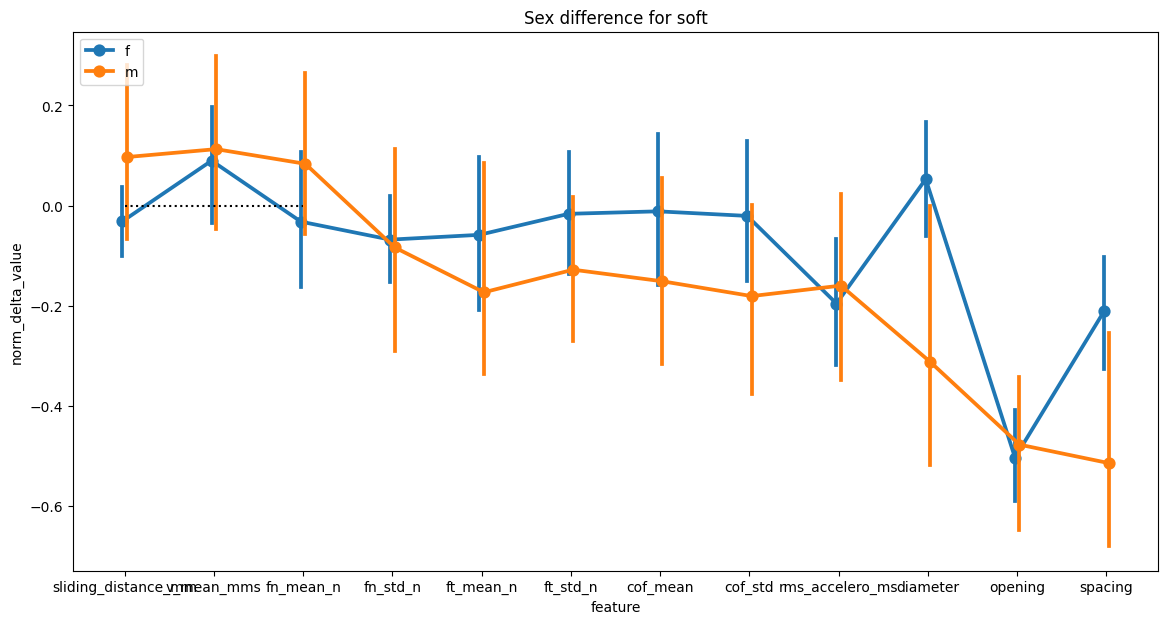

In [69]:
plt.figure(figsize=(14,7))
sns.pointplot(data=kernels[kernels.condition=='soft'],
              hue="sex",
             x="feature",
              units='subj',
             y="norm_delta_value", dodge=True)
plt.title("Sex difference for soft")
plt.plot([0,2],[0,0],'k:')
plt.legend(loc=2)

In [70]:
print("Two-sample difference of kernel weights between male and female soft")
for feature in ['diameter','opening','spacing']: 
    print('- %s'%(feature))
      
    sample_male = kernels[(kernels.condition=='soft')&
                          (kernels.sex=='m')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()

    sample_female = kernels[(kernels.condition=='soft')&
                          (kernels.sex=='f')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()
    
    stats= pg.ttest(x=sample_male.norm_delta_value, 
                    y=sample_female.norm_delta_value)
    
    print('t(%d)=%.2f,p=%.4f'%(stats.loc['T-test','dof'],
                               stats.loc['T-test','T'],
                               stats.loc['T-test','p-val']))

Two-sample difference of kernel weights between male and female soft
- diameter
t(3)=-1.71,p=0.1720
- opening
t(6)=-0.16,p=0.8768
- spacing
t(3)=-1.82,p=0.1430


Remember that the first few participants (3 ?) had a bug that resulted in not stopping the recording at the time of response

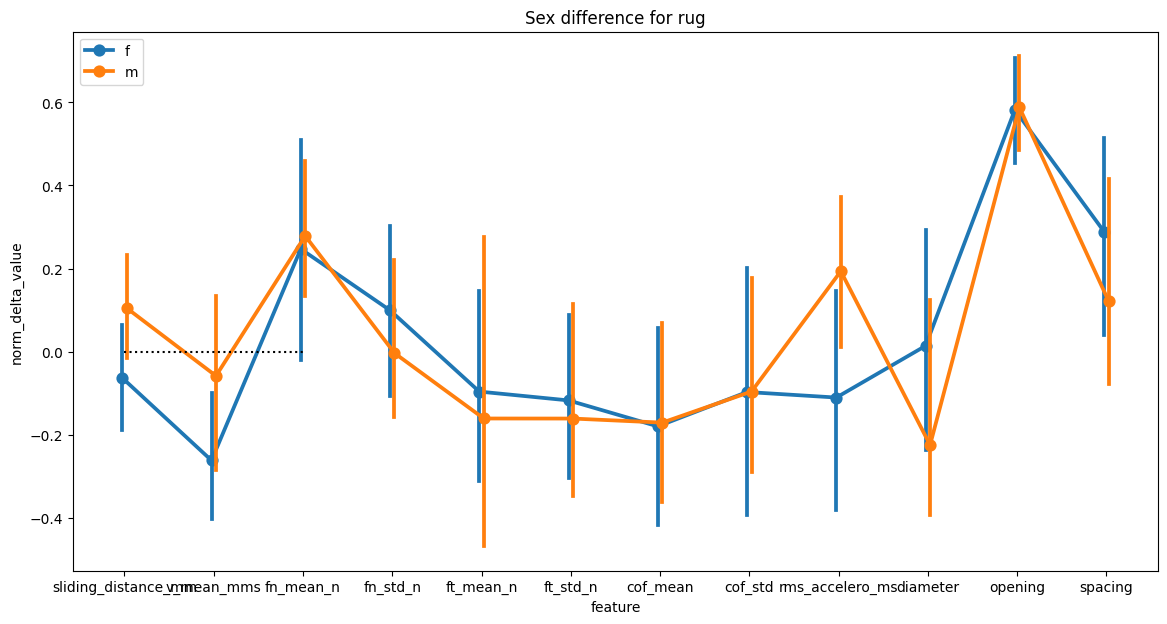

In [71]:
plt.figure(figsize=(14,7))
sns.pointplot(data=kernels[kernels.condition=='rug'],
              hue="sex",
             x="feature",
              units='subj',
             y="norm_delta_value", dodge=True)
plt.title("Sex difference for rug")
plt.plot([0,2],[0,0],'k:')
plt.legend(loc=2)